In [1]:
import torch
from torch import Tensor
import numpy as np

#### Modules

In [2]:
class Module(object):
    def forward(self, *input):
        raise NotImplementedError
    def backward(self, *gradwrtoutput):
        raise NotImplementedError
    def param(self):
        return []
    def update(self, lr=None):
        pass

In [3]:
class Linear(Module):
    """Implements the fully connected layer module
    
    It requires the number of inputs and outputs.

    Weights are initialized assuming that a ReLU module
    will be used afterwards. If a Tanh module will be used
    instead, it is recommended to set
    std_w = 1 / np.sqrt(n_input)
    
    It is possible to set a default learning rate that will be used
    during backpropagation if no other learning rate is stated.
    """
    def __init__(self, n_input, n_output, lr=1e-5,
        std_w=None, bias=True, std_b=0):

        if std_w is None:
            # "Xavier" initialization
            std_w = 1 / np.sqrt(.5 * n_input)
        
        # Set parameters
        self.lr = lr
        self.w = Tensor(n_output, n_input).normal_(0, std_w)
        self.dw = Tensor(self.w.size()).zero_()
        self.cum_dw = Tensor(self.w.size()).zero_()
        self.bias = bias
        
        if bias:
            if not std_b:
                self.b = Tensor(n_output, 1).fill_(0)
            else:
                self.b = Tensor(n_output, 1).normal_(0, std_b)
            self.db = Tensor(self.b.size()).zero_()
            self.cum_db = Tensor(self.b.size()).zero_()

    def forward(self, x):
        """Carries out the forward pass for backpropagation."""
        if len(x.shape) < 2:
            # reshape if required
            x = x.view(-1,1)
        self.x = x
        self.s = self.w @ x
        if self.bias:
            self.s += self.b
        return self.s

    def backward(self, grad):
        """Carries out the backward pass for backpropagation.
        It does not update the parameters.
        """
        if len(grad.shape) < 2:
            # reshape if required
            grad = grad.view(1,-1)
        out = grad @ self.w
        self.dw = (self.x @ grad).t()
        self.cum_dw.add_(self.dw)
        if self.bias:
            self.db = grad.t()
            self.cum_db.add_(self.db)
        return out

    def param(self):
        """Returns the list of parameters and gradients."""
        out = [(self.w, self.dw)]
        if self.bias:
            out.append((self.b, self.db))
        return out
    
    def update(self, lr=None):
        """Updates the parameters with the accumulated gradients.
        It must be called explicitly. If no lr is stated, the
        default lr of the module is used.
        """
        if lr is None:
            lr = self.lr
        self.w.add_(-lr * self.cum_dw)
        self.cum_dw = Tensor(self.w.size()).zero_()
        if self.bias:
            self.b.add_(-lr * self.cum_db)
            self.cum_db = Tensor(self.b.size()).zero_()

In [4]:
class ReLU(Module):
    """Implements the Rectified Linear Unit activation layer"""
    def forward(self, x):
        """Carries out the forward pass for backpropagation."""
        self.x = x
        return self.x.clamp(min=0)

    def backward(self, grad):
        """Carries out the backward pass for backpropagation."""
        return grad * Tensor(np.where(self.x <= 0,
            0, 1)).view(grad.size())

In [5]:
class LeakyReLU(Module):
    """Implements the Leaky ReLU activation layer"""
    def __init__(self, a=.001):
        self.a = a
        
        """Carries out the forward pass for backpropagation."""
        self.x = x
        return Tensor(np.where(x >= 0, x, self.a * x ))

    def backward(self, grad):
        """Carries out the backward pass for backpropagation."""
        return grad * Tensor(np.where(self.x >= 0,
            1, self.a)).view(grad.size())

In [6]:
class Tanh(Module):
    """Implements the Tanh activation layer"""
    def forward(self, x):
        """Carries out the forward pass for backpropagation."""
        self.x_tanh = x.tanh()
        return self.x_tanh

    def backward(self, grad):
        """Carries out the backward pass for backpropagation."""
        return grad * (1 - self.x_tanh ** 2).view(grad.size())

In [7]:
class Sigmoid(Module):
    """Implements the Rectified Linear Unit activation layer
    It is recommended to use the Tanh module instead.
    """
    def forward(self, x):
        """Carries out the forward pass for backpropagation."""
        self.sigmoid = (1 + (x / 2).tanh()) / 2
        return self.sigmoid

    def backward(self, grad):
        """Carries out the backward pass for backpropagation."""
        return grad * (self.sigmoid * (1 - self.sigmoid)).view(grad.size())

In [8]:
class LossMSE(Module):
    """Implements the MSE loss computation"""
    def forward(self, output, target):
        """Carries out the forward pass for backpropagation."""
        self.diff = output.float() - target.float().view(output.size())
        return (self.diff ** 2).sum()

    def backward(self):
        """Carries out the backward pass for backpropagation."""
        return self.diff * 2

In [9]:
class Sequential(Module):
    """Allows to combine several modules sequentially
    It is possible to either include a loss module in the Sequential
    module or to not include it and use a loss module defined outside
    of the Sequential module instead.
    """
    def __init__(self, layers, loss=None):
        self.layers = layers
        self.loss = loss

    def forward(self, x, target=None):
        """Carries out the forward pass for backpropagation
        To do it it calls the forward functions of each individual
        module.
        """
        if self.loss is not None:
            assert target is not None, "Target required for loss module"
        for l in self.layers:
            x = l.forward(x)
        if self.loss is not None:
            x = self.loss.forward(x, target)
        self.x = x
        return x

    def backward(self, grad=None):
        """Carries out the backward pass for backpropagation
        To do it it calls the backward functions of each individual
        module
        """
        if self.loss is not None:
            grad = self.loss.backward()
        else:
            assert grad is not None, "Initial gradient required when no loss module defined"
        for l in reversed(self.layers):
            grad = l.backward(grad)

    def param(self):
        return [p for l in layers for p in l.param()]
    
    def update(self, lr=None):
        for l in self.layers:
            l.update(lr)

In [10]:
## Example 1:

l1 = Linear(3, 2, lr=.1)
l2 = Tanh()
l3 = Linear(2, 1, lr=.1)
l4 = Tanh()

layers = [l1, l2, l3, l4]
loss = LossMSE()

s = Sequential(layers, loss)

#Forward
x = Tensor([1,.5,1])
L = s.forward(x, Tensor([1]))
print("L:{}".format(L))

#Backward
s.backward()



## Example 2:

l1 = Linear(3, 2, lr=.1)
l2 = Tanh()
l3 = Linear(2, 1, lr=.1)
l4 = Tanh()

layers = [l1, l2, l3, l4]
loss = LossMSE()

s = Sequential(layers)

#Forward
x = Tensor([1,.5,1])
y = s.forward(x)

L = loss.forward(y, Tensor([1]))
print("L:{}".format(L))

#Backward
grad = loss.backward()
s.backward(grad)

L:0.3130382299423218
L:0.5811281204223633


#### Training

In [11]:
def adaptive_lr(kappa=0.75, eta0=1e-5):
    """Adaptive learning rate. After creating the lr with the
    values for kappa and eta0, it yields the value for the learning
    rate of the next iteration. Used for (Stochastic) Gradient Descent
    methods.
    """
    t = 1
    while True:
        yield eta0 * t ** -kappa
        t += 1

In [12]:
def SGD(model, loss, train_input, train_target, n_epochs, mini_batch_size, a_lr):
    """Trains a model, which is usually defined as a Sequential module"""
    for e in range(n_epochs):
        L_tot = 0
        errors_tot = 0

        p = np.random.permutation(len(train_target))
        train_zipped = zip(train_input[p], train_target[p])
        predicted_labels = []        
        
        for i, (data, label) in enumerate(train_zipped):
            d = Tensor(data)
            l = Tensor(1).fill_(label)

            # Forward pass
            output = model.forward(d)
            L = loss.forward(output, l)
            predicted_labels.append(output)            

            # Backward pass
            grad = loss.backward()
            model.backward(grad)

            # update gradients
            if not (i + 1) % mini_batch_size:
                next_a_lr = next(a_lr)
                model.update(next_a_lr)
            
            # Compute total loss and accuracy
            L_tot += L
            errors = (l != (output >= 0.5).float() ).sum()
            errors_tot += errors
            
        next_a_lr = next(a_lr)
        model.update(next_a_lr)

        accuracy = (len(train_target) - errors_tot) / len(train_target)
        print('Epoch {:d}  Loss {:.08f}  Accuracy {:.02f}  Errors {}'.format(
            e, L_tot, accuracy, errors_tot))
    
    return train_input[p], train_target[p], np.array(predicted_labels)

#### Generate dataset

Where is the disk centered? We assume (0,0)

In [13]:
def generate_disc_set(nb):
    data = np.random.uniform(0, 1, size=(nb, 2))
    label = ((data - .5) ** 2).sum(1) <= 1 / (2 * np.pi)
    return data, label.astype(float)

In [14]:
train_input, train_target = generate_disc_set(1000)
train_data_0 = train_input[train_target == 0]
train_data_1 = train_input[train_target == 1]

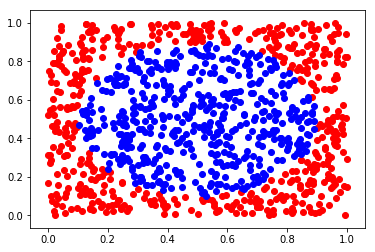

In [15]:
# Plot data points
import matplotlib.pyplot as plt
plt.scatter(train_data_0.transpose()[0], train_data_0.transpose()[1], c="red")
plt.scatter(train_data_1.transpose()[0], train_data_1.transpose()[1], c="blue")
plt.show()

#### Test
Why two output units?

In [16]:
def get_rand_params():
    """Generates random parameters for testing purposes"""
    kappas = np.linspace(.5, .95, 30)
    #kappas = np.linspace(.76, .92, 10)
    
    etas = np.logspace(-7, -1, 30)
    #etas = np.logspace(-4.32, -2, 10)
    
    mbs = np.linspace(20, 160, 30).round()
    
    return (np.random.choice(kappas),
           np.random.choice(etas),
           np.random.choice(mbs))

In [17]:
# Some good parameter combinations:
#k:0.593103448275862, e0:0.014873521072935119, mb:112.0
#k:0.5, e0:0.009236708571873866, mb:34.0
#k:0.6241379310344828, e0:0.03856620421163472, mb:92.0

k, e0, mb = (.6, 3.5e-2, 60)
a_lr = adaptive_lr(kappa=k, eta0=e0)

loss = LossMSE()
hl1 = [Linear(2, 25, lr=0), ReLU()]
hl2 = [Linear(25, 25, lr=0), ReLU()]
hl3 = [Linear(25, 25, lr=0), ReLU()]
out = [Linear(25, 1, lr=0), Sigmoid()]

model = Sequential(hl1 + hl2 + hl3 + out)

p_data, p_target, pred_labels = SGD(model, loss, train_input, train_target, 200, mb, a_lr)
pred_labels = (pred_labels >= 0.5)

Epoch 0  Loss 375.02357791  Accuracy 0.49  Errors 514
Epoch 1  Loss 236.81257086  Accuracy 0.63  Errors 374
Epoch 2  Loss 230.70660017  Accuracy 0.65  Errors 351
Epoch 3  Loss 223.44113150  Accuracy 0.70  Errors 300
Epoch 4  Loss 217.20262854  Accuracy 0.72  Errors 283
Epoch 5  Loss 207.99289186  Accuracy 0.73  Errors 269
Epoch 6  Loss 198.92953621  Accuracy 0.74  Errors 259
Epoch 7  Loss 191.10043386  Accuracy 0.75  Errors 247
Epoch 8  Loss 183.16476624  Accuracy 0.76  Errors 241
Epoch 9  Loss 175.18963323  Accuracy 0.78  Errors 224
Epoch 10  Loss 169.41248172  Accuracy 0.79  Errors 214
Epoch 11  Loss 162.88418756  Accuracy 0.79  Errors 213
Epoch 12  Loss 158.28910494  Accuracy 0.80  Errors 200
Epoch 13  Loss 152.64935538  Accuracy 0.80  Errors 199
Epoch 14  Loss 147.11178312  Accuracy 0.82  Errors 176
Epoch 15  Loss 140.94829137  Accuracy 0.84  Errors 164
Epoch 16  Loss 136.63433339  Accuracy 0.85  Errors 152
Epoch 17  Loss 133.78925845  Accuracy 0.84  Errors 157
Epoch 18  Loss 129.6

Epoch 153  Loss 28.04162769  Accuracy 0.99  Errors 12
Epoch 154  Loss 27.84399379  Accuracy 0.99  Errors 9
Epoch 155  Loss 28.69592203  Accuracy 0.99  Errors 13
Epoch 156  Loss 27.85315369  Accuracy 0.99  Errors 11
Epoch 157  Loss 28.99061559  Accuracy 0.99  Errors 13
Epoch 158  Loss 27.61964375  Accuracy 0.99  Errors 9
Epoch 159  Loss 27.52092072  Accuracy 0.99  Errors 11
Epoch 160  Loss 27.95078457  Accuracy 0.99  Errors 10
Epoch 161  Loss 27.57369849  Accuracy 0.99  Errors 10
Epoch 162  Loss 27.37363873  Accuracy 0.99  Errors 9
Epoch 163  Loss 27.04044227  Accuracy 0.99  Errors 9
Epoch 164  Loss 27.06488107  Accuracy 0.99  Errors 10
Epoch 165  Loss 26.84556303  Accuracy 0.99  Errors 8
Epoch 166  Loss 27.20628208  Accuracy 0.99  Errors 12
Epoch 167  Loss 26.37396067  Accuracy 0.99  Errors 12
Epoch 168  Loss 26.67194021  Accuracy 0.99  Errors 11
Epoch 169  Loss 26.86026830  Accuracy 0.99  Errors 8
Epoch 170  Loss 26.55009082  Accuracy 0.99  Errors 9
Epoch 171  Loss 26.77669651  Accura

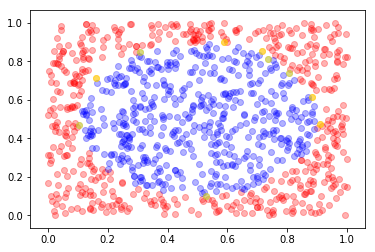

In [18]:
pred_data_errors = p_data[pred_labels != p_target]

# Plot predicted labels
plt.scatter(train_data_0.transpose()[0], train_data_0.transpose()[1], c="red", alpha=.3)
plt.scatter(train_data_1.transpose()[0], train_data_1.transpose()[1], c="blue", alpha=.3)
plt.scatter(pred_data_errors.transpose()[0], pred_data_errors.transpose()[1], c="yellow", alpha=.5)

plt.show()

Loss 26.06431415  Accuracy 0.98  Errors 21


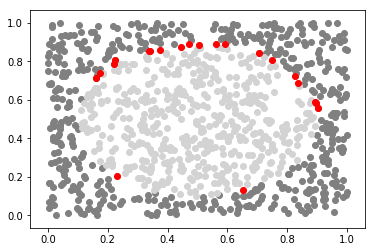

In [19]:
test_input, test_target = generate_disc_set(1000)

def testing(model, loss, test_input, test_target):
    """Tests a model, which is usually defined as a Sequential module"""
    L_tot = 0
    errors_tot = 0

    test_zipped = zip(test_input, test_target)
    predicted_labels = []

    for data, label in test_zipped:
        d = Tensor(data)
        l = Tensor(1).fill_(label)

        # Get predicted label and loss
        output = model.forward(d)
        predicted_labels.append(output)
        L = loss.forward(output, l)

        # Compute total loss and accuracy
        L_tot += L
        errors = (l != (output >= 0.5).float() ).sum()
        errors_tot += errors

    accuracy = (len(test_target) - errors_tot) / len(test_target)
    print('Loss {:.08f}  Accuracy {:.02f}  Errors {}'.format(
        L_tot, accuracy, errors_tot))
    
    return np.array(predicted_labels)

pred_labels = testing(model, loss, test_input, test_target)
pred_labels = (pred_labels >= 0.5)

test_data_0 = test_input[test_target == 0]
test_data_1 = test_input[test_target == 1]
pred_data_errors = test_input[pred_labels != test_target]

# Plot data points

plt.scatter(test_data_0.transpose()[0], test_data_0.transpose()[1], c="gray", alpha=1)
plt.scatter(test_data_1.transpose()[0], test_data_1.transpose()[1], c="lightgray", alpha=1)
plt.scatter(pred_data_errors.transpose()[0], pred_data_errors.transpose()[1], c="red", alpha=1)
plt.show()